<a href="https://colab.research.google.com/github/Igor-Pi/Misc/blob/main/prep_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
tf.__version__

'2.9.2'

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Thu Nov 10 07:15:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
IMG_WIDTH = 704
IMG_HIGHT = 520
TRAIN_SIZE = 0.9
TRAIN_PATH = os.getcwd()+'/train/'

In [3]:
files = os.listdir('train')
files = list(filter(lambda x: x.endswith('.png'), files))
idx = tf.random.shuffle(tf.range(len(files)))
edge = int(np.floor(len(idx) * TRAIN_SIZE))
train_files = tf.data.Dataset.from_tensor_slices(
    pd.DataFrame(files).loc[idx[:edge]].values.reshape(edge))
valid_files = tf.data.Dataset.from_tensor_slices(
    pd.DataFrame(files).loc[idx[edge:]].values.reshape(len(files) - edge))

In [ ]:
# список файлов в каталоге train
#dataset = tf.data.Dataset.list_files(os.getcwd()+'/sandbox/*.png', shuffle=False)
# делаем train и valid (см. выше)

## Dataset prepearing 

In [4]:
# open GT-file
gt_file = tf.io.read_file(os.getcwd()+'/train/labels.csv')
# spliting to strings
gt_file = tf.strings.split(gt_file, sep=os.linesep)
# taking of id and annotation
gt_file = tf.strings.split(gt_file, sep=',')[:, :2].to_tensor()

In [5]:
def parse_image(filename, path=TRAIN_PATH):
    """
    Convert image to tensor of float32
    
    Args:
    - filename (string). filename to read from
    
    Returns:
    A tensor of dtype float 32, with the file contents
    """
    image = tf.io.read_file(path + filename)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, [128, 128])
    label = parse_GT(filename)
    return image, label

In [6]:
#@tf.function
def numb_to_coord(pix_numbers):
    y = (pix_numbers - 1) % IMG_WIDTH
    x = (pix_numbers - 1) // IMG_WIDTH
    pix_coord = tf.stack([x, y], axis=1)
    return pix_coord

def rle_to_numb(rle):
    return rle[0] + tf.range(rle[1])

def uniq_pix_indexes(pix):
    indexes = np.unique(pix[:,:2], axis=0, return_index=True)[1]
    return tf.constant(pix[indexes], dtype=tf.int64)

In [7]:
@tf.function
def parse_GT(img_path, gt_file=gt_file):
    
    # из переданного пути к снимку выбираем имя файла без расширения (код снимка)
    img = tf.strings.split(tf.strings.split(img_path, sep=os.sep)[-1], sep='.')[0]
    #  подготовка маски-фильтра по переданному имени файла (коду снимка)
    img_filter = gt_file[:,0] == img
    # выборка снимка из списка (наложение маски-фильтра) выбираем реквизит 1, где хранится описание сегментов 
    gt_file = gt_file[img_filter][:, 1]
    # формирование справочника [начальный пиксель : длина сегмента]
    gt_file = tf.strings.split(gt_file)
    # преобразование в числовой вид
    rles = tf.cast(tf.strings.to_number(gt_file), tf.int32)
    # в этот массив собираем координаты и номера объектов; формат: [x, y, номер объекта]
    pix_obj = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    # собственно rles не итерируемый, т.к. размерность в графовом режиме не определена
    # но есть возможность узнать длины строк, по которым и будем итерировать rles 
    iterator = tf.cast(rles.row_lengths(), dtype=tf.int32)
    idx = 0     # этот (индекс + 1) будет номером объекта
    idx_1 = 0   # этот используется как итератор по пикселям одного объекта
    # этот цикл по объектам
    for numb_chain in iterator:
        # решейпим данные rle объекта в вид [начало, количество пикселей]
        # в длину получается по количеству цепочек
        #obj.assign(tf.reshape(rles[idx], shape=[numb_chain/2, 2]))
        obj = tf.reshape(rles[idx], shape=[numb_chain/2, 2])
        # преобразовываем rle в цепочки номеров пикселей 
        ragged = tf.map_fn(rle_to_numb, obj, fn_output_signature=tf.RaggedTensorSpec(shape=[None],dtype=tf.int32))
        # цепочки пикселей переводим в координаты (тензор пока рваный)
        ragged = tf.map_fn(numb_to_coord, ragged).values
        # этот цикл по пикселям объекта
        for pixs in ragged:
            pix_obj = pix_obj.write(idx_1, tf.concat([pixs, tf.fill(dims=[1], value=idx+1)], axis=0))
            idx_1 += 1
        idx += 1
    # здесь используем numpy, т.к. tf.unique умеет работать только с векторами, 
    # а нам надо выбрать уникальные комбинации [x,y] 
    pixel_masks = tf.numpy_function(uniq_pix_indexes, [pix_obj.stack()], tf.int64)
    # собственно sparse из нулей и номеров объектов
    pixel_masks = tf.sparse.to_dense(
        tf.sparse.SparseTensor(
            indices=tf.cast(pixel_masks[:,:2], dtype=tf.int64), 
            values=tf.cast(pixel_masks[:,-1], dtype=tf.int64), 
            dense_shape=[IMG_HIGHT, IMG_WIDTH]))
    return pixel_masks

#tf_speed_test = tf.function(speed_test)

In [ ]:
#print(parse_GT.get_concrete_function('/train/0a6ecc5fe78a.png').graph.as_graph_def())

In [ ]:
# как только получится стабилизировать граф, необходимо выполнить этот код
# моё предположение, что здесь будет дохрена чего, т.к. на входе в numb_to_coord и rle_to_numb
# много разных размерностей, а для каждой будет строиться отдельный граф
# И, внимание, вопрос - а получим ли мы увеличение производительности а таком случае?

#print(parse_GT.pretty_printed_concrete_signatures())

In [ ]:
%%time
#obj = tf.Variable(0, shape=tf.TensorShape(None))
# FILE_NAME = tf.constant(os.getcwd()+'/sandbox/01ae5a43a2ab.png')
# ass = parse_GT(FILE_NAME)
# plt.imshow(ass)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.3 µs


In [8]:
train = train_files.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid = valid_files.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
BATCH_SIZE = 2
BUFFER_SIZE = 545
# BATCH_SIZE = 2
# BUFFER_SIZE = 10

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
def show_image_from_dataset(dataset):
    '''displays the first image and its mask from a dataset'''
    fig, ax = plt.subplots(figsize=(15,24))
    
    for image in dataset.take(1):
        ax.imshow(tf.squeeze(image[0][0], 2))
        ax.imshow(image[1][0], alpha=0.2)

In [11]:
train_dataset.element_spec

(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 520, 704), dtype=tf.int64, name=None))

CPU times: user 16min 40s, sys: 3.61 s, total: 16min 43s
Wall time: 9min 19s


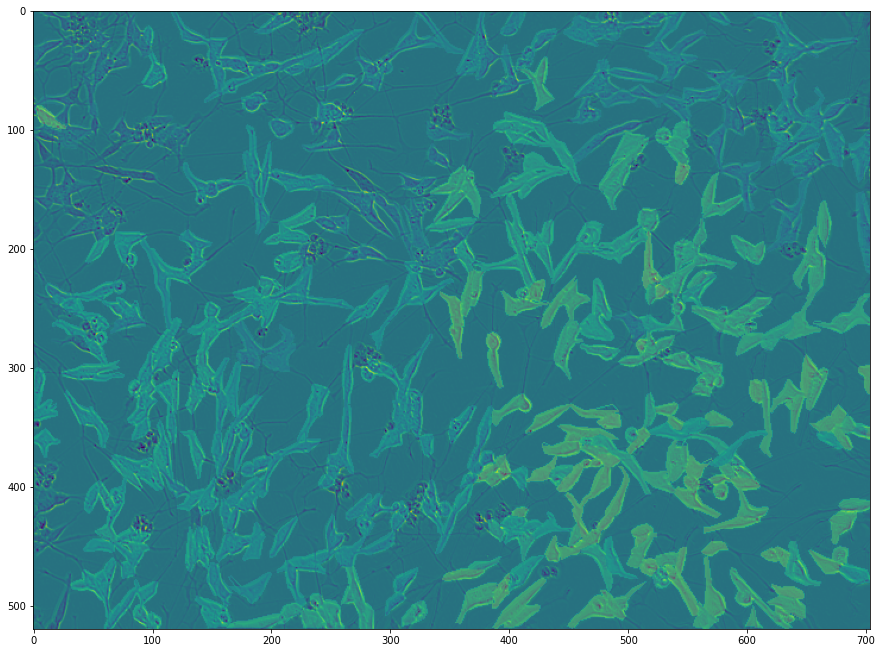

In [12]:
%%time
show_image_from_dataset(train_dataset)

## Architect

### Encoder

In [13]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    '''
    Adds 2 convolutional layers with the parameters passed to it

    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution

    Returns:
        tensor of output features
    '''
    # first layer
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.

    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution

    Returns:
        f - the output features of the convolution block 
        p - the maxpooled features with dropout
    '''

    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p


def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
        inputs (tensor) -- batch of input images

    Returns:
        p4 - the output maxpooled features of the last encoder block
        (f1, f2, f3, f4) - the output features of all the encoder blocks
    '''
    f1, p1 = encoder_block(inputs, n_filters=8, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=16, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=32, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=64, pool_size=(2,2), dropout=0.3)

    return p4, (f1, f2, f3, f4)
    # return p2, (f1, f2)

### Bottleneck

In [14]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''

    # bottle_neck = conv2d_block(inputs, n_filters=1024)
    bottle_neck = conv2d_block(inputs, n_filters=128)

    return bottle_neck

### Decoder

In [15]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, padding = 'same', dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
        inputs (tensor) -- batch of input features
        conv_output (tensor) -- features from an encoder block
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size
        strides (int) -- strides for the deconvolution/upsampling
        padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
        c (tensor) -- output features of the decoder block
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = padding)(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c


def decoder(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
        inputs (tensor) -- batch of input features
        convs (tuple) -- features from the encoder blocks
        output_channels (int) -- number of classes in the label map

    Returns:
        outputs (tensor) -- the pixel wise label map of the image
    '''

    f1, f2, f3, f4 = convs
    # f1, f2 = convs

    c6 = decoder_block(inputs, f4, n_filters=64, kernel_size=(3,2), strides=(2,2), padding='valid', dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=32, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    # c8 = decoder_block(inputs, f2, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=16, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=8, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

    return outputs

### Model

In [18]:
OUTPUT_CHANNELS = 531

def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(520, 704, 1,), name='image')

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model = tf.keras.Model(inputs=inputs, outputs=bottle_neck)
    return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 520, 704, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 520, 704, 8)  80          ['image[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 520, 704, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 520, 704, 8)  0           ['conv2d_1[0][0]']           

In [19]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
%%time
# configure the training parameters and train the model

TRAIN_LENGTH = len(train)
EPOCHS = 2
#VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/2
272/272 [==============================] - 104s 337ms/step - loss: nan - accuracy: 0.8684
Epoch 2/2
272/272 [==============================] - 92s 334ms/step - loss: nan - accuracy: 0.8945
CPU times: user 1min 14s, sys: 6.64 s, total: 1min 20s
Wall time: 3min 23s


In [21]:
!nvidia-smi

Thu Nov 10 09:25:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------